In [62]:
import glob
import io
import math
import os

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

from keras import applications
from keras import optimizers
from keras.applications.inception_v3 import InceptionV3
from keras import layers
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from keras import backend as K
from keras import utils

In [40]:
# Configure the TF backend session
tf_config = tf.ConfigProto(
    gpu_options=tf.GPUOptions(allow_growth=True))
K.set_session(tf.Session(config=tf_config))
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format
BASE_DIR = '/home/kamal/codes/deepLearning/hackerEarth/'
IMG_SIZE = 64

In [79]:
train_data = np.load(BASE_DIR + 'trainbeg.npy')
test_data = np.load(BASE_DIR + 'testbeg.npy')
print("train_data shape: ", train_data.shape)
print("test_data shape:", test_data.shape)

ValueError: cannot reshape array of size 159744000 into shape (13000,150,150,3)

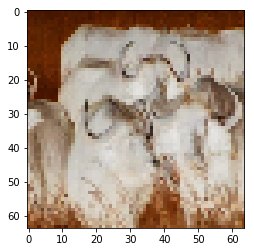

In [42]:
plt.imshow(np.array(train_data[12]))

In [43]:
train = train_data[:9100]
print(train.shape)
validation = train_data[9100:]
print(validation.shape)

(9100, 64, 64, 3)
(3900, 64, 64, 3)


In [44]:
labels = np.load(BASE_DIR + 'trainLabels.npy')
print(labels.shape)
train_labels = labels[:9100]
print(train_labels.shape)
validation_labels = labels[9100:]
print(validation_labels.shape)

(13000, 1)
(9100, 1)
(3900, 1)


In [77]:
local_weights_file = '/home/kamal/codes/deepLearning/hackerEarth/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

AttributeError: 'Model' object has no attribute 'reshape'

In [46]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [47]:
last_layer = pre_trained_model.get_layer('mixed7')
print("last layer output shape", last_layer.output_shape)
last_output = last_layer.output

last layer output shape (None, 7, 7, 768)


In [64]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation= 'sigmoid')(x)
model = Model(pre_trained_model.input, x)
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.0001),
              metrics = ['accuracy'])
labels = np.load(BASE_DIR + 'trainLabels.npy')
one_hot_labels = utils.to_categorical(labels, num_classes=30)

In [56]:
# Define our example directories and files
train_dir = os.path.join(BASE_DIR, 'train_dir')
test_dir = os.path.join(BASE_DIR, 'test_dir')

# Directory with our training pictures
train_data_dir = os.path.join(train_dir, 'train_data')

# Directory with our testing pictures
test_data_dir = os.path.join(test_dir, 'test_data')

train_data_fnames = os.listdir(train_data_dir)
test_data_fnames = os.listdir(test_data_dir)

from keras.preprocessing.image import ImageDataGenerator

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        class_mode=None)

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode=None)

Found 13000 images belonging to 1 classes.
Found 6000 images belonging to 1 classes.


In [74]:
hist = model.fit(train_data, one_hot_labels, epochs=2, batch_size=50)
#history = model.fit_generator(
                             # train_generator,
                             # steps_per_epoch=100,
                              #epochs=2,
                             # verbose=2,
                              #validation_data=validation_generator,
                              #validation_steps=50,
                              #use_multiprocessing=True)

ValueError: Error when checking input: expected input_3 to have shape (150, 150, 3) but got array with shape (64, 64, 3)

In [20]:
unfreeze = False
for layer in pre_trained_model.layers:
    if unfreeze:
        layer.trainable = True
    if layer.name == 'mixed6':
        unfreeze = True
from keras.optimizers import SGD
model.compile(loss = 'binary_crossentropy',
              optimizer = SGD(lr = 0.00001, momentum = 0.9),
              metrics = ['acc'])

In [21]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/50
 - 315s - loss: 1.4383e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2/50
 - 315s - loss: 1.4138e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3/50
 - 312s - loss: 1.5420e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4/50
 - 245s - loss: 1.4281e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 5/50
 - 237s - loss: 1.4102e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 6/50
 - 242s - loss: 1.4466e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 7/50
 - 255s - loss: 1.4848e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 8/50
 - 256s - loss: 1.4234e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 9/50
 - 310s - loss: 1.4234e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 10/50
 - 307s - loss: 1.4412e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 11/50
 - 318s - loss: 1.4442e-07 - acc: 1.0000 - val_loss: 1.19

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

NameError: name 'history' is not defined